In [2]:
% matplotlib inline

import sys
from data_models.parameters import arl_path

results_dir = arl_path('test_results')

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame

from wrappers.arlexecute.execution_support.arlexecute import arlexecute

from wrappers.serial.skycomponent.operations import find_skycomponents
from wrappers.serial.visibility.base import create_blockvisibility
from wrappers.serial.image.operations import show_image
from wrappers.serial.simulation.testing_support import create_named_configuration, \
    create_low_test_skycomponents_from_gleam
from wrappers.serial.imaging.primary_beams import create_low_test_beam
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field

from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility

from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow

import logging
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))


In [3]:
nfreqwin = 1
ntimes = 1
rmax = 300
frequency = numpy.linspace(0.8e8, 1.2e8, nfreqwin)
if nfreqwin > 1:
    channel_bandwidth = numpy.array(nfreqwin * [frequency[1] - frequency[0]])
else:
    channel_bandwidth = [0.4e8]
times = numpy.linspace(-numpy.pi / 4.0, numpy.pi / 4.0, ntimes)

phasecentre = SkyCoord(ra=+0.0 * u.deg, dec=-26.7 * u.deg, frame='icrs', equinox='J2000')
lowcore = create_named_configuration('LOWBD2', rmax=rmax)

block_vis = create_blockvisibility(lowcore, times, frequency=frequency,
                                   channel_bandwidth=channel_bandwidth, weight=1.0, phasecentre=phasecentre,
                                   polarisation_frame=PolarisationFrame("stokesI"), zerow=True)


create_configuration_from_file: Maximum radius 300.0 m includes 94 antennas/stations
create_blockvisibility: 1 rows, 0.000 GB


### Find the station locations in geocentric coordinates

In [4]:
station_locations = block_vis.configuration.xyz

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


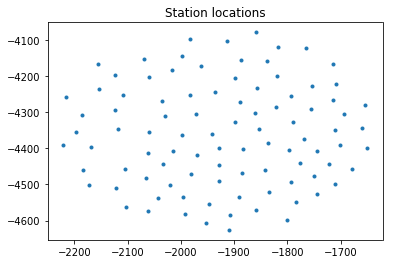

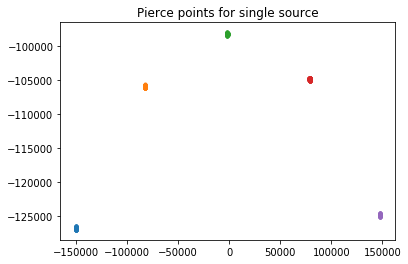

In [5]:
from processing_library.util.coordinate_support import xyz_to_uvw, skycoord_to_lmn

local_locations = xyz_to_uvw(station_locations, 0.0, -26.7 * u.deg)

ionosphere_height = 3e5
plt.clf()
plt.plot(local_locations[:, 0], local_locations[:, 1], '.')
plt.title('Station locations')
plt.show()

def find_pp(local_locations, ha, dec):
    source_direction = SkyCoord(ra=ha, dec=dec, frame='icrs', equinox='J2000')
    local_locations = xyz_to_uvw(station_locations, ha, dec)
    
    lmn = numpy.array(skycoord_to_lmn(source_direction, phasecentre))
    lmn[2] += 1.0
    pierce_points = local_locations + ionosphere_height * numpy.array(lmn)
    return pierce_points

plt.clf()

for ha in numpy.linspace(-numpy.pi / 4.0, +numpy.pi / 4.0, 5):
    pp = find_pp(local_locations, ha * u.rad, -45 * u.deg)
    plt.plot(pp[:, 0], pp[:, 1], '.')

plt.title('Pierce points for single source')

plt.show()


In [6]:
wprojection_planes=1
vis = convert_blockvisibility_to_visibility(block_vis)
advice=advise_wide_field(vis, guard_band_image=5.0, delA=0.02, 
                         wprojection_planes=wprojection_planes)

vis_slices = advice['vis_slices']
npixel=advice['npixels2']
cellsize=advice['cellsize']

convert_visibility: Original 1 rows, 0.000 GB, converted 4371 rows, 0.000 GB
advise_wide_field: Maximum wavelength 3.747 (meters)
advise_wide_field: Minimum wavelength 3.747 (meters)
advise_wide_field: Maximum baseline 142.2 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)
advise_wide_field: Image field of view 0.535344 (rad) 30.673 (deg)
advise_wide_field: Synthesized beam 0.007034 (rad) 0.403 (deg)
advise_wide_field: Cellsize 0.002345 (rad) 0.134 (deg)
advice_wide_field: Npixels per side = 228
advice_wide_field: Npixels (power of 2) per side = 256
advice_wide_field: Npixels (power of 2, 3) per side = 256
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)
advice_wide_field: Time sampling for full image = 43.0 (s)
advice_wide_field: Time sampling for primary beam = 1074.3 (s)
advice_wide_field: Frequency sampling for full ima

Generate the model from the GLEAM catalog, including application of the primary beam.

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0., -26.7)>, starting frequency 80000000.0 Hz, and bandwidth 39999999.9996 Hz
create_image_from_visibility: uvmax = 76.504970 wavelengths
create_image_from_visibility: Critical cellsize = 0.006536 radians, 0.374458 degrees
create_image_from_visibility: Cellsize          = 0.002345 radians, 0.134346 degrees
create_low_test_skycomponents_from_gleam: 1977 sources above flux limit 0.100
import_image_from_fits: created >f4 image of shape (1, 1, 256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000
create_low_test_beam: primary beam is defined at 100.000 MHz
apply_beam_to_skycomponent: Processing 1977 components
apply_beam_to_skycomponent: 1977 components with total flux [[239.9566482]]
Number of components

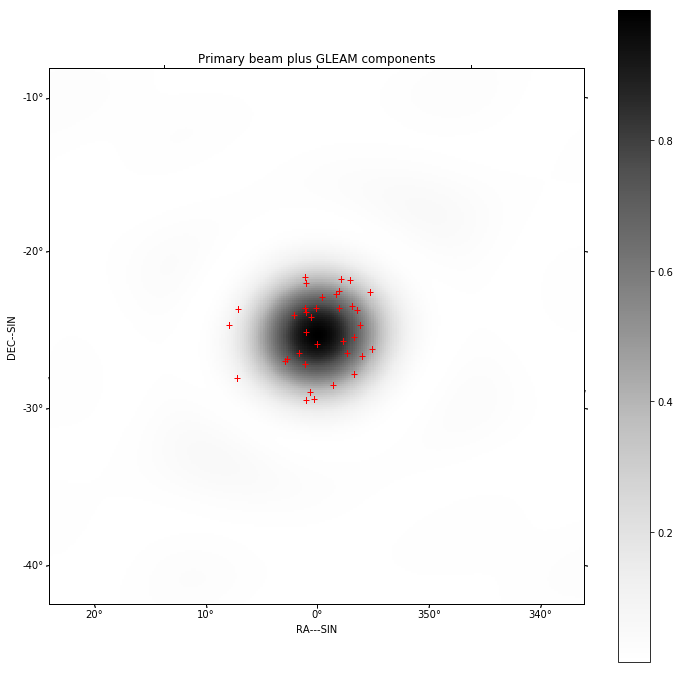

In [9]:
beam = create_image_from_visibility(block_vis, npixel=npixel, frequency=frequency,
                                    nchan=nfreqwin, cellsize=cellsize, phasecentre=phasecentre)

original_gleam_components = create_low_test_skycomponents_from_gleam(flux_limit=0.1,
                                                                     phasecentre=phasecentre, frequency=frequency,
                                                                     polarisation_frame=PolarisationFrame('stokesI'),
                                                                     radius=0.2)

beam = create_low_test_beam(beam)
pb_gleam_components = apply_beam_to_skycomponent(original_gleam_components, beam)
from processing_components.skycomponent.operations import filter_skycomponents_by_flux

pb_gleam_components = filter_skycomponents_by_flux(pb_gleam_components, flux_min=1.0)
from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

show_image(beam, components=pb_gleam_components, cm='Greys', title='Primary beam plus GLEAM components')
print("Number of components %d" % len(pb_gleam_components))


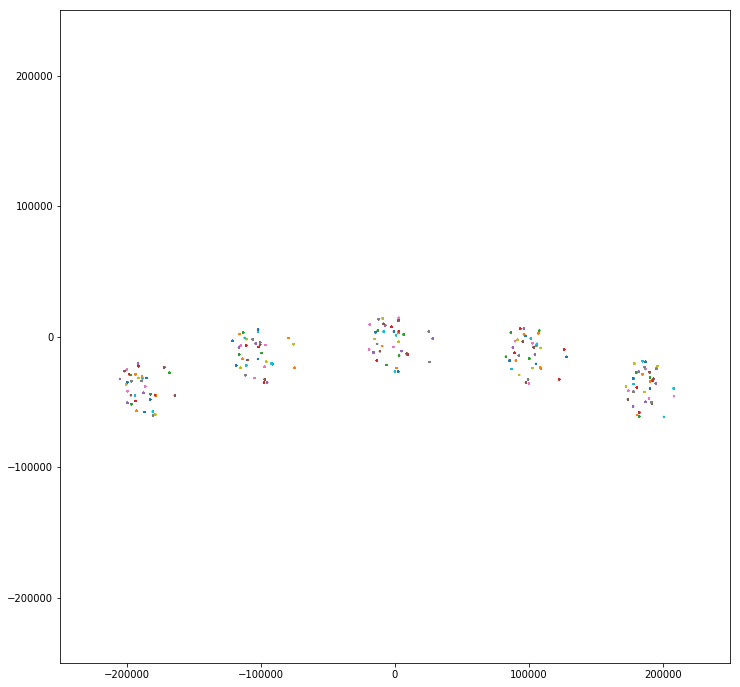

In [10]:
plt.clf()
for ha in numpy.linspace(-numpy.pi / 4.0, +numpy.pi / 4.0, 5):
    for comp in pb_gleam_components:
        pp = find_pp(local_locations, (comp.direction.ra.rad + ha) * u.rad, comp.direction.dec)
        plt.plot(pp[:, 0], pp[:, 1])

plt.xlim([-2.5e5, 2.5e5])
plt.ylim([-2.5e5, 2.5e5])
plt.show()
